In [1]:
embed_dim=100
G=4
#batch_size=80
number_of_negative_tokens = 5
n_epochs = 30
n_workers=64
queue_size = 64
padding_length=3
title_length_percentile=95
desc_length_percentile=90

import os, time, json,pandas as pd, numpy as np, re, string, random,sys
from collections import Counter,defaultdict
import Levenshtein


from keras.layers import Input,Lambda,Conv1D,GlobalMaxPool1D,concatenate,Dense,Dropout,PReLU,TimeDistributed,Embedding,Activation
from keras import Model
import keras.backend as K
import keras
from keras.utils import Sequence
import tensorflow as tf



df= pd.read_csv('yummly.csv')


# In[7]:


/Users/jermainemarshall/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df.WHO.value_counts()

1    30405
2    26269
3    15468
4     8259
5     4050
0     3357
6     1413
7      192
Name: WHO, dtype: int64

In [3]:
#!pip3 install python-levenshtein
#!pip3 install setuptools

# strip punctuation and combine ingredients into one word separated by a spae

df['RECIPE'] = df['RECIPE'].str.replace('\d+', '')
df['RECIPE'] = df['RECIPE'].str.replace(' ', '')
df['RECIPE'] = df['RECIPE'].str.replace('#.,', ' ')
df['RECIPE'] = df['RECIPE'].str.replace('#.', '')

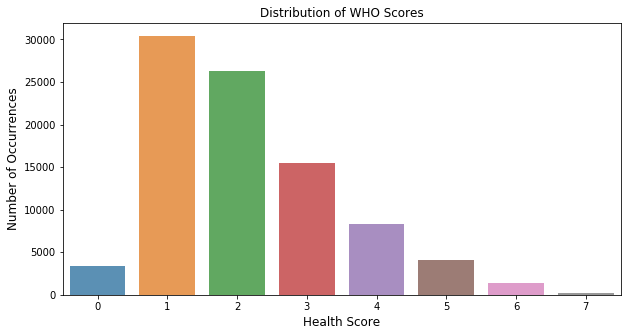

In [7]:
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
who_scores= df.WHO.value_counts()
plt.figure(figsize= (10,5))
sns.barplot(who_scores.index, who_scores.values, alpha=0.8)
plt.title('Distribution of WHO Scores')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Health Score', fontsize=12)
plt.show()

In [ ]:
df['WHO'] = df['WHO'].replace({0:'zero', 1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', 6: 'six', 7: 'seven'})

In [ ]:
pd.options.display.max_colwidth= 500
df.head(4)

In [ ]:
from sklearn.model_selection import train_test_split
#(X_train, X_test) = train_test_split(df2,test_size=0.20)


#with tf.device('/gpu:0'):
X_train, X_validation, X_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

descTokenCounts = pd.Series(' '.join(df['RECIPE']).split())

In [ ]:
descTokenCounts= descTokenCounts.value_counts().to_dict()

In [ ]:
descTokenCounts.get('fineseasalt')

In [ ]:




df= df.drop_duplicates()


df= df.dropna()


def remove_non_ascii_1(text):

    return ''.join([i if ord(i) < 128 else ' ' for i in text])

def remove_non_ascii_2(text):

    return re.sub(r'[^\x20-\x7E]+',' ', text)

vocabSize=20000
tokens = sorted(descTokenCounts.items(),key=lambda x:x[1],reverse=True)[:vocabSize]

tokens = [i[0] for i in tokens]
tokens.append('token_unknown')
token_to_index = {}
index_to_token = {}


df['WHO'] = ([remove_non_ascii_1(sentence) for sentence in df['WHO']])
df['WHO'] = ([remove_non_ascii_2(sentence) for sentence in df['WHO']])


df['RECIPE']= ([remove_non_ascii_1(sentence) for sentence in df['RECIPE']])


# In[13]:




df['RECIPE']= ([remove_non_ascii_2(sentence) for sentence in df['RECIPE']])



In [ ]:
df.head(4)

In [ ]:
model_name = 'allmy_jermaine_model1_jerm'


from sklearn.model_selection import train_test_split
#(X_train, X_test) = train_test_split(df2,test_size=0.20)


#with tf.device('/gpu:0'):
X_train, X_validation, X_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])



with open('alltrain_data.json', 'wb') as f:
    f.write(X_train.to_json(orient='records', lines=True).encode('ascii', 'ignore'))

    
with open('alltest_data.json', 'wb') as g:
    g.write(X_test.to_json(orient='records', lines=True).encode('ascii', 'ignore'))


    
with open('allvalidation_data.json', 'wb') as t:
    t.write(X_validation.to_json(orient='records', lines=True).encode('ascii', 'ignore'))

def loadData(dataPath):
    data=[]
    start_time = time.time()
    with open(dataPath) as f:
        for line in f:
            data.append(line)
    loadTime = time.time() - start_time

    #print loadTime
    return data

training_data = loadData('alltrain_data.json')
validation_data = loadData('allvalidation_data.json') 
test_data = loadData('alltest_data.json') 


In [ ]:
title_length= df['WHO'].map(len)
desc_length= df['RECIPE'].map(len)
titleCounts = df['WHO'].value_counts().to_dict()

charset=set(list(string.ascii_lowercase)+list(map(str,range(10)))+list("?$*!: @ ^ %- / <> ~ ` \\ [] {} \n = | \" _+#&-/\n %() ' '.;,"))
title_char_to_index_dict={c:i for i,c in enumerate(charset)}
title_index_to_char_dict={i:c for c,i in title_char_to_index_dict.items()}

In [ ]:
print(title_char_to_index_dict)

In [ ]:



for i in range(len(tokens)):
    token_to_index[tokens[i]] = i+1
    index_to_token[i+1] = tokens[i] 


with open('allmodels_indices.json'.format(model_name),'w') as f:
    json.dump({'title_char_to_index_dict':title_char_to_index_dict,'title_index_to_char_dict':title_index_to_char_dict,              'token_to_index':token_to_index,'index_to_token':index_to_token},f)


    
title_max_len = np.ceil(np.percentile(title_length, title_length_percentile)).astype(int)

def title_char_tokenizer(entity,entity_max_len):
    preproced_entity=(" "*padding_length+entity)[:entity_max_len]
    padded_entity=preproced_entity+"".join([" "]*(entity_max_len-len(preproced_entity)))
    return [title_char_to_index_dict[i] for i in padded_entity]


## RECIPE tokenizer
## 0 padded in the end
desc_max_length = np.ceil(np.percentile(desc_length, desc_length_percentile)).astype(int)
def job_description_tokenizer(desc,entity_max_len):
    desc = re.sub("[,\/]",' ',desc).split()
    desc = [token_to_index[i] if i in token_to_index else token_to_index['token_unknown'] for i in desc]
    desc=(desc+[0]*entity_max_len)[:entity_max_len]
    return desc

In [ ]:
with open ('allallmodels_model_params.json'.format(model_name),'w') as f:
    json.dump({'title_max_len':int(title_max_len),'desc_max_length':int(desc_max_length)},f)
    
## character embedding model for a list of titles
def char_embed_model_seq(input_layer,char_length,char_index_dict,entity_name,n_filters=512,embed_dim=embed_dim):
    '''
    Same as char_embed_model, but produces embeddings for a sequence of say, titles.
    Applies the same layers (as char_embed_model) to each member of the sequence
    '''    
    entity_onehot_layer=TimeDistributed(Lambda(lambda x: K.one_hot(x,len(char_index_dict)),output_shape=(char_length,len(char_index_dict))),name=entity_name+'_onehot_seq')(input_layer)
        
    conv7_layer=TimeDistributed(Conv1D(filters=n_filters,kernel_size=4,activation='relu'),name=entity_name+'_conv_7seq')(entity_onehot_layer)
    maxpool7_layer=TimeDistributed(GlobalMaxPool1D(),name=entity_name+'maxpool1seq')(conv7_layer)

    conv3_layer=TimeDistributed(Conv1D(filters=n_filters,kernel_size=2,activation='relu'),name=entity_name+'_conv_3seq')(entity_onehot_layer)
    maxpool3_layer=TimeDistributed(GlobalMaxPool1D(),name=entity_name+'maxpool2seq')(conv3_layer)

    pools_concat=keras.layers.concatenate([maxpool7_layer,maxpool3_layer],name=entity_name+'_maxpools_concatseq')
    #pools_dropped=(pools_concat)

    entity_dense_layer=TimeDistributed(Dense(n_filters*2,activation='relu'),name=entity_name+'_intermediate_denseseq')(pools_concat)
    
    dropout_layer=TimeDistributed(Dropout(0.4),name=entity_name+"_droppedseq")(entity_dense_layer)
    
    entity_final_dense=TimeDistributed(Dense(embed_dim),name=entity_name+'_last_denseseq')(dropout_layer)
    entity_prelu_layer=TimeDistributed(PReLU(),name=entity_name+'_preluseq')(entity_final_dense)
    embed_norm_layer=TimeDistributed(Lambda(lambda x: x/(K.epsilon()+K.sqrt(K.batch_dot(x,x,axes=-1)))),name=entity_name+'_unit_norm_embedseq')(entity_prelu_layer)

    entity_embed_model=keras.models.Model(input_layer,embed_norm_layer,name=entity_name+"_embedding_model")
    return entity_embed_model




# In[25]:


## job describtion embedding - average word embedding (remove 0 padding)
def desc_embed_model(input_layer,vocab_size,entity_name,embed_dim=embed_dim):
    wordEmbed = Embedding(input_dim = vocab_size,output_dim = embed_dim, name='word_embedding')(input_layer) 
    
    ## get average embedding for desc (remove 0 padding)
    mask=Lambda(lambda x: K.cast(K.minimum(1,K.cast(x,'int32')),'float32'),name='mask')(input_layer)
    mask_summed=Lambda(lambda x: 1/(K.epsilon()+K.sum(x,axis=-1)),name='mask_summed')(mask)
    mask_normed=keras.layers.multiply([mask,mask_summed],name='mask_normed')
    desc_embedding_averaged=keras.layers.dot([wordEmbed,mask_normed],axes=1,name='desc_embedding_averaged')
    
    desc_embed_model=Model(input_layer,desc_embedding_averaged,name=entity_name+"_embedding_model")
    return desc_embed_model
# In[26]:


alpha=0.5
sampling_titles = titleCounts.keys()

sampling_titles= [k for k in titleCounts.keys()]


# In[27]:


sampling_titles_array = np.array(sampling_titles)


# In[28]:


sampling_prob_array = np.array(list(titleCounts.values()))
sampling_prob_array = np.power(sampling_prob_array,alpha)
sampling_prob_array = sampling_prob_array/sum(sampling_prob_array)


# In[29]:


def sampling_based_on_similarity(title,sub_sampling_titles,number_of_negative_tokens=5):
## Randomly sample sub_sampling_titles based on emperical distribution
## Randomly sample titles from the selected sub-titles based on Levenshtein similarity
    st = time.time()
    sampling_titles = np.array(sub_sampling_titles)

    sampling_prob = np.array([Levenshtein.ratio(title,i) for i in sub_sampling_titles])#Levenshtein.ratio(title,i) for i in sub_sampling_titles])
    sampling_prob = sampling_prob/sum(sampling_prob)
    
    samples=np.random.choice(sampling_titles,size=number_of_negative_tokens,p=sampling_prob)
  
    return samples.tolist()



In [ ]:
class empirical_sampling_gen(Sequence):

    def __init__(self, data, batch_size,number_of_negative_tokens,sampling_titles,sampling_prob,sub_sampling_size):
        '''        
        batch_size: number of resumes to process per batch        
        The actual number of training samples varies as each resume is splitted into sub-sequences
        '''
        self.batch_size = batch_size
        self.input_data = data
        self.data_length = len(data)
        self.number_negative_tokens = number_of_negative_tokens
        self.sampling_titles = sampling_titles
        self.sampling_prob = sampling_prob
        self.sub_sampling_size = sub_sampling_size
    def __len__(self):
        return int(np.ceil(self.data_length / float(self.batch_size)))
    

    def __getitem__(self, idx):
        i = idx
        batch_size = self.batch_size 
        desc_input_batch=[]
        title_input_batch=[]
        y_pos_batch=[]
        y_neg_batch=[] 
        titles = []
        for k in range(i * batch_size, min((i + 1) * batch_size, self.data_length)):
            line = json.loads(self.input_data[k])
            desc = job_description_tokenizer(line['RECIPE'],desc_max_length)
            #desc = str(desc)
            titles.append(line['WHO'])
            title = title_char_tokenizer(line['WHO'],title_max_len)
            #title= str(title)
            desc_input_batch.append(desc)
            title_input_batch.append([title]*self.number_negative_tokens)
            y_pos_batch.append(1)
            y_neg_batch.append([0]*self.number_negative_tokens)  
            
        ## Sample negative titles for each batch all together              
        neg_titles = np.random.choice(self.sampling_titles, size=len(titles)*self.number_negative_tokens,p=self.sampling_prob)
        
        ## Resample for titles with length below median title length based on Levenshtein similarity
        sub_sampling_titles = np.random.choice(self.sampling_titles,p=self.sampling_prob,                                               size=self.sub_sampling_size*len(titles),replace=True)
        for i,t in enumerate(titles):
            if np.random.random()>0.5:
                sub_titles = sub_sampling_titles[i*self.sub_sampling_size:(i+1)*self.sub_sampling_size]
                samples = sampling_based_on_similarity(t,sub_titles)
                neg_titles[i*self.number_negative_tokens:(i+1)*self.number_negative_tokens]=samples
        
        neg_title_input_batch = [title_char_tokenizer(t,title_max_len) for t in neg_titles]
        neg_title_input_batch = [neg_title_input_batch[x:x+self.number_negative_tokens]                                  for x in range(0, len(neg_title_input_batch), self.number_negative_tokens)]
        
        
             
        ## Convert inputs and output to numpy arrays
        inputs = list(map(np.array,[desc_input_batch,title_input_batch,neg_title_input_batch]))
        outputs = list(map(np.array,[y_pos_batch,y_neg_batch]))     
        #return (inputs, outputs,titles,neg_titles) 
        #print(inputs)
        return (inputs, outputs) 
    

    def on_epoch_end(self):
        #'Shuffle data after each epoch'
        np.random.shuffle(self.input_data)



# In[ ]:


# In[31]:


batch_size=100


# In[32]:


trainGen = empirical_sampling_gen(training_data,batch_size,number_of_negative_tokens,                                  sampling_titles_array,sampling_prob_array,sub_sampling_size=2200)                                 



#len(title_char_to_index_dict)


# In[33]:



testGen = empirical_sampling_gen(test_data,batch_size,number_of_negative_tokens,                                    sampling_titles_array,sampling_prob_array,sub_sampling_size=1500)


# In[34]:


validateGen = empirical_sampling_gen(validation_data,batch_size,number_of_negative_tokens,                                    sampling_titles_array,sampling_prob_array,sub_sampling_size=2200)                                 


# In[35]:


target_title_input=Input(shape=(number_of_negative_tokens,title_max_len), dtype='int32', name='targe_title_input')
neg_title_input = Input(shape=(number_of_negative_tokens,title_max_len), dtype='int32', name='ne_title_input')
title_embedding_model = char_embed_model_seq(target_title_input,title_max_len,title_char_to_index_dict,"titlee")
target_title_embed = title_embedding_model(target_title_input)
target_title_embed = Lambda(lambda x:x[:,0,:],name='title_embedding_take_first_elemente')(target_title_embed)
neg_title_embed = title_embedding_model(neg_title_input)



# In[36]:


## Get resume job description embedding
desc_input = Input(shape=(desc_max_length,),name='des_input')
desc_embedding_model = desc_embed_model(desc_input,vocabSize+2,'des')
desc_embed = desc_embedding_model(desc_input)

## Calcuate dot product and loss
desc_target_title_dot = keras.layers.dot([target_title_embed,desc_embed],axes=-1,name='des_target_dot')
pos_title_logit = Activation('sigmoid',name='po_title_logit')(desc_target_title_dot)

desc_neg_title_dot = keras.layers.dot([neg_title_embed,desc_embed],axes=-1,name='des_neg_dot')
neg_title_logit = Activation('sigmoid',name='ne_title_logit')(desc_neg_title_dot)


In [ ]:
original_model=Model(inputs=[desc_input,target_title_input,neg_title_input],outputs=[pos_title_logit,neg_title_logit])


original_model.compile(optimizer='adam',metrics=['accuracy'],
                       loss=['binary_crossentropy','binary_crossentropy'],loss_weights=[1.,1.])                    

In [ ]:
from keras.utils import plot_model

(plot_model(original_model, show_shapes= True, to_file='model.png'))

In [ ]:
original_model.fit_generator(trainGen,verbose=1,validation_data=validateGen,epochs=10, steps_per_epoch = 160,
                             workers=n_workers,max_queue_size=queue_size,use_multiprocessing=False,shuffle=True)


In [ ]:
open('recipe_yummly_model.json'.format(model_name), 'w').write(original_model.to_json())


# In[ ]:


original_model.save_weights('recipe_yummly_model.hdf5'.format(name=model_name))



In [ ]:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.subplot(212) 
plt.plot(original_model.history['neg_rec_loss']) 
plt.plot(original_model.history['val_neg_rec_loss']) 
plt.plot(original_model.history['pos_rec_loss'])  
plt.plot(original_model.history['val_pos_rec_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.savefig('alltloss')
plt.legend(['neg train', 'neg val', 'pos train', 'pos val'], loc='upper left')  
plt.show()


# In[ ]:



# In[ ]:


#plt.figure(1)\n",
plt.subplot(211) 
plt.plot(history.history['neg_rec_acc']) 
plt.plot(history.history['val_neg_rec_acc'])  
plt.plot(history.history['pos_recipe_acc'])  
plt.plot(history.history['val_pos_recipe_acc'])
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')
#plt.ylim(0,0.7)
plt.savefig('allstacc')
plt.legend(['neg t.acc', 'neg v.acc', 'pos t.acc', 'pos v.acc', 'upper left'])


# In[ ]:


#import matplotlib.pyplot as plt
#get_ipython().run_line_magic('matplotlib', 'inline')
#plt.subplot(212) 
#plt.plot(history.history['neg_title_logit_loss']) 
#plt.plot(history.history['val_neg_title_logit_loss']) 

